# Multivariate LSTM Modelling Version 2

In this notebook, we will use PyTorch to construct a multivariate LSTM model to forecast the daily adjusted close price of NVIDIA stock.

**Note:** This is version 2 of multivariate LSTM modelling contained in this project where we now move from 5 to 15 predictor variables. We do this by incorporating technical indicators that we calculate from the existing time series data such RSI, moving averages etc. As a result, we are now moving into a potentially "very" nonlinear environment and the aim is to see how the LSTM model handles the nature of this more complex problem.

We also train the LSTM model with a larger time frame of data to see if this also improves performance.

## Setup

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from Functions import tsPlot
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import gp_minimize
from tqdm import tqdm  # for progress bar
from IPython.display import clear_output, display

from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Enable GPU

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

### Import Data

Now we load in the time series data for and cut it down to a 5 year period for 2018 to 2023 and store it in the dataframe called 'df_ret' and 'df_exog'

In [3]:
# Read the csv file into a pandas DataFrame
df_ret = pd.read_csv('../DataManagement/daily_data.csv', parse_dates=['DATE'], index_col='DATE')

# Drop everything except the columns we need for this scenario
df_ret = df_ret.filter(['DATE', 'NVDA_OPEN', 'NVDA_HIGH', 'NVDA_LOW', 'NVDA_CLOSE', 'NVDA_VOLUME'])

df_ret.head()

,NVDA_OPEN,NVDA_HIGH,NVDA_LOW,NVDA_CLOSE,NVDA_VOLUME
DATE,,,,,
2010-01-05,4.225095,4.348957,4.225095,4.303082,7.941654e+07
2010-01-06,4.300790,4.339784,4.259502,4.330608,7.075387e+07
2010-01-07,4.307669,4.326019,4.213625,4.245738,5.970476e+07
2010-01-08,4.211332,4.284732,4.186100,4.254913,5.211632e+07
2010-01-11,4.277850,4.296200,4.135638,4.195275,6.066607e+07


Create additional features from the time series data.

* **SMA_20:** Simple Moving Average (SMA) with a window of 20. SMA is the average price of a security over a specified number of time periods, and it helps smooth out price fluctuations to identify trends.

* **SMA_50:** Simple Moving Average (SMA) with a window of 50. Similar to SMA_20, but with a longer window, which can provide a more significant trend signal.

* **EMA_20:** Exponential Moving Average (EMA) with a window of 20. EMA gives more weight to recent prices, making it more sensitive to recent price changes compared to the SMA.

* **EMA_50:** Exponential Moving Average (EMA) with a window of 50. Similar to EMA_20, but with a longer window for a smoother long-term trend indication.

* **RSI:** Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100 and is used to identify overbought or oversold conditions.

* **MACD:** Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator calculated as the difference between two Exponential Moving Averages (EMA) – typically, a 12-period EMA and a 26-period EMA. It helps identify trend changes and potential buy/sell signals.

* **MACD_signal:** The signal line for the MACD, usually a 9-period EMA of the MACD line. It helps generate buy/sell signals when it crosses the MACD line.

* **BB_upper:** The upper band of the Bollinger Bands (BB). Bollinger Bands consist of three lines: the middle (SMA) and the upper and lower bands, which are calculated based on the standard deviation of the price. They help identify potential overbought and oversold conditions.

* **BB_middle:** The middle band of the Bollinger Bands (BB). It represents the SMA and provides a reference point for the other bands.

* **BB_lower:** The lower band of the Bollinger Bands (BB). It is calculated based on the standard deviation of the price and helps identify potential oversold conditions.

In [4]:
# Calculate Simple Moving Averages (SMA)
df_ret['SMA_20'] = SMAIndicator(df_ret['NVDA_CLOSE'], window=20).sma_indicator()
df_ret['SMA_50'] = SMAIndicator(df_ret['NVDA_CLOSE'], window=50).sma_indicator()

# Calculate Exponential Moving Averages (EMA)
df_ret['EMA_20'] = EMAIndicator(df_ret['NVDA_CLOSE'], window=20).ema_indicator()
df_ret['EMA_50'] = EMAIndicator(df_ret['NVDA_CLOSE'], window=50).ema_indicator()

# Calculate Relative Strength Index (RSI)
df_ret['RSI'] = RSIIndicator(df_ret['NVDA_CLOSE']).rsi()

# Calculate Moving Average Convergence Divergence (MACD)
macd = MACD(df_ret['NVDA_CLOSE'])
df_ret['MACD'] = macd.macd()
df_ret['MACD_signal'] = macd.macd_signal()

# Calculate Bollinger Bands (BB)
bollinger = BollingerBands(df_ret['NVDA_CLOSE'])
df_ret['BB_upper'] = bollinger.bollinger_hband()
df_ret['BB_middle'] = bollinger.bollinger_mavg()
df_ret['BB_lower'] = bollinger.bollinger_lband()

# Specify the date range
start_date = '2012-06-30'
end_date = '2023-06-30'

# Slice the DataFrame for the desired date range
df_ret = df_ret.loc[start_date:end_date].copy()

df_ret.head()

,NVDA_OPEN,NVDA_HIGH,NVDA_LOW,NVDA_CLOSE,NVDA_VOLUME,SMA_20,SMA_50,EMA_20,EMA_50,RSI,MACD,MACD_signal,BB_upper,BB_middle,BB_lower
DATE,,,,,,,,,,,,,,,
2012-07-02,3.186024,3.188318,3.059868,3.085099,6.339869e+07,2.908938,2.900635,2.953446,2.972066,57.663951,0.049553,0.019496,3.159471,2.908938,2.658406
2012-07-03,3.085098,3.172261,3.082804,3.165380,2.390013e+07,2.928779,2.903250,2.973630,2.979647,61.019761,0.059685,0.027534,3.194115,2.928779,2.663443
2012-07-05,3.144736,3.158499,3.085099,3.133268,3.052594e+07,2.943345,2.907103,2.988834,2.985671,59.005034,0.064380,0.034903,3.219769,2.943345,2.666921
2012-07-06,3.110330,3.119505,3.039223,3.073630,4.171765e+07,2.960662,2.908571,2.996910,2.989121,55.349888,0.062568,0.040436,3.223851,2.960662,2.697474
2012-07-09,3.055280,3.069042,3.007111,3.032342,3.338807e+07,2.973278,2.909168,3.000284,2.990816,52.906453,0.057142,0.043778,3.224542,2.973278,2.722015


## Plots

As usual, we qucikly plot the time series to make sure that looks as we expect

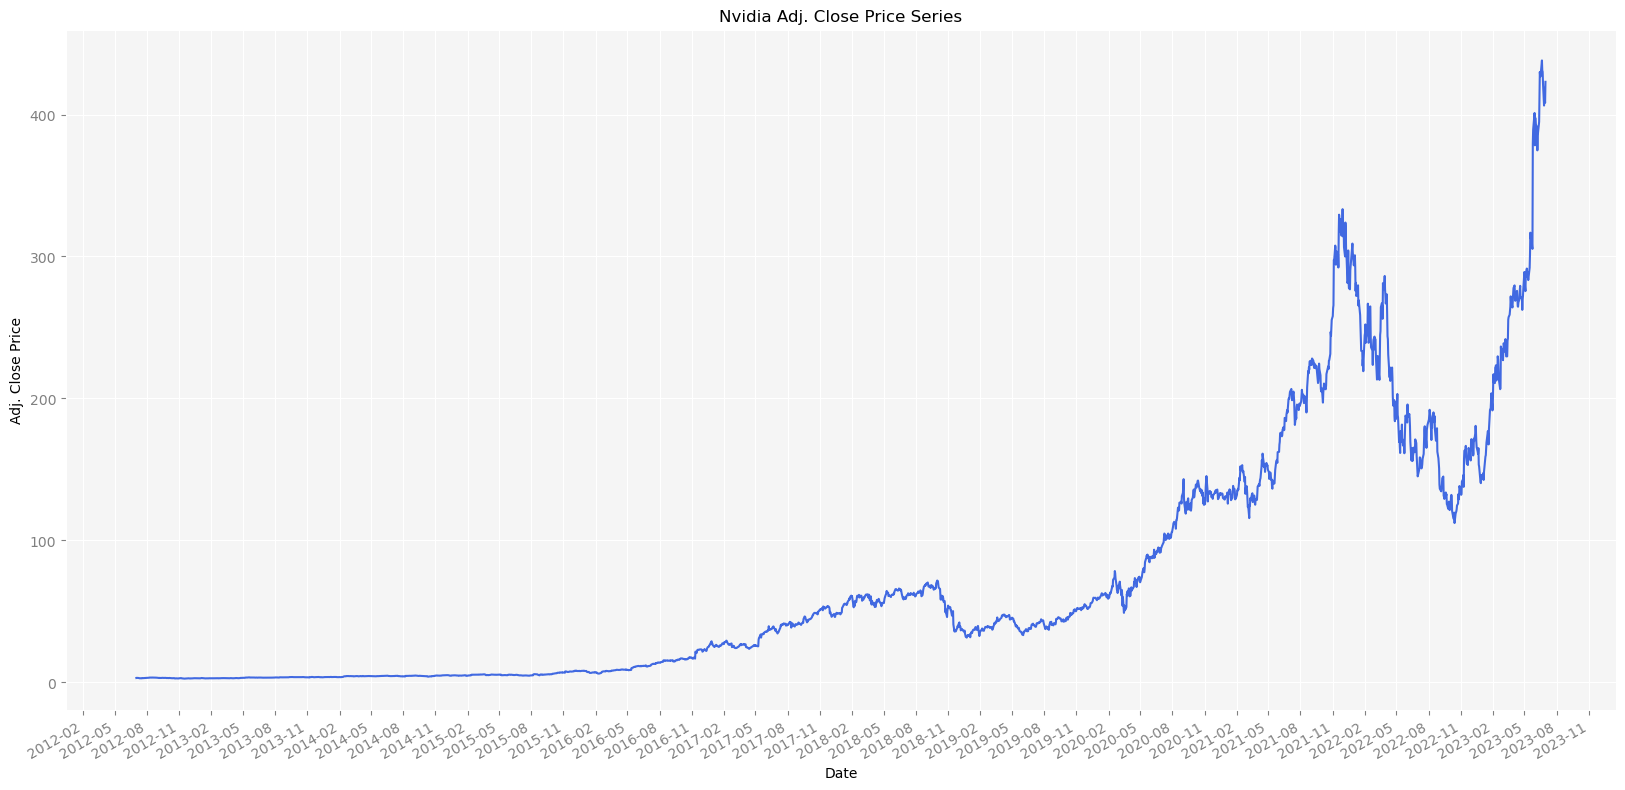

In [5]:
tsPlot(df_ret['NVDA_CLOSE'], "Nvidia", "Adj. Close Price")

## Data Pre-Processing

### Create Sequences

Here we define a function that transforms the data into the format requred by the LSTM with parameters for lookback period.

In [6]:
def prepare_data_lstm(data, n_steps, column):
    column_names = [column]
    data = dc(data)  # make deep copy of the input data

    for i in range(1, n_steps+1):
        column_name = f'{column}(t-{i})'
        column_names.append(column_name)
        data[column_name] = data[column].shift(i)

    data.dropna(inplace=True)
    data = data.loc[:, data.columns.intersection(column_names)]

    return data

Now, since we are working with multivariate data, we need to be careful to make sure that our X matrix follows the structure laid out in the diagram found in the README file. We will effectively call the prepare_data_lstm function on each feature seperaterly to generate the sequences and then perform some transformations afterwards to combine the data into a single X matrix as needed.

In [7]:
lookback = 7

timeseries_columns = ['NVDA_CLOSE', 'NVDA_OPEN', 'NVDA_HIGH', 'NVDA_LOW', 'NVDA_VOLUME']
indicator_columns = ['SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_signal', 'BB_upper', 'BB_middle', 'BB_lower']

# Same as the univariate case
shifted_close = prepare_data_lstm(df_ret, lookback, 'NVDA_CLOSE')    

# New: now we also perform the same procedure on each of the additional features that we wish to include in our X matrix
shifted_open = prepare_data_lstm(df_ret, lookback, 'NVDA_OPEN')
shifted_high = prepare_data_lstm(df_ret, lookback, 'NVDA_HIGH')
shifted_low = prepare_data_lstm(df_ret, lookback, 'NVDA_LOW')
# shifted_volume = prepare_data_lstm(df_ret, lookback, 'NVDA_VOLUME')       **REMOVED**

# Then the same process for all of the technical indicators we want to include in our X matrix
shifted_SMA20 = prepare_data_lstm(df_ret, lookback, 'SMA_20')
# shifted_SMA50 = prepare_data_lstm(df_ret, lookback, 'SMA_50')             **REMOVED
shifted_EMA20 = prepare_data_lstm(df_ret, lookback, 'EMA_20')
# shifted_EMA50 = prepare_data_lstm(df_ret, lookback, 'EMA_50')             **REMOVED**
shifted_RSI = prepare_data_lstm(df_ret, lookback, 'RSI')
shifted_MACD = prepare_data_lstm(df_ret, lookback, 'MACD')
shifted_MACD_SIGNAL = prepare_data_lstm(df_ret, lookback, 'MACD_signal')
shifted_BB_UPPER = prepare_data_lstm(df_ret, lookback, 'BB_upper')
# shifted_BB_MIDDLE = prepare_data_lstm(df_ret, lookback, 'BB_middle')      **REMOVED**
# shifted_BB_LOWER = prepare_data_lstm(df_ret, lookback, 'BB_lower')        **REMOVED**

# Now we convert the dataframes into numpy matrices
shifted_close_np = shifted_close.to_numpy()
shifted_open_np = shifted_open.to_numpy()
shifted_high_np = shifted_high.to_numpy()
shifted_low_np = shifted_low.to_numpy()
# shifted_volume_np = shifted_volume.to_numpy()              **REMOVED**
shifted_SMA20_np = shifted_SMA20.to_numpy()
# shifted_SMA50_np = shifted_SMA50.to_numpy()                **REMOVED**
shifted_EMA20_np = shifted_EMA20.to_numpy()
# shifted_EMA50_np = shifted_EMA50.to_numpy()                **REMOVED**
shifted_RSI_np = shifted_RSI.to_numpy()
shifted_MACD_np = shifted_MACD.to_numpy()
shifted_MACD_SIGNAL_np = shifted_MACD_SIGNAL.to_numpy()
shifted_BB_UPPER_np = shifted_BB_UPPER.to_numpy()
# shifted_BB_MIDDLE_np = shifted_BB_MIDDLE.to_numpy()         **REMOVED**
# shifted_BB_LOWER_np = shifted_BB_LOWER.to_numpy()           **REMOVED**

Now we perform standardisation on the dataset. We have to be careful here because some variables are recorded on very different scales, for example, volume figures are magnitudes larger than open, high, low and close figures. As a result, we will scale volume seperately to the other variables so that we do not introduce bias into the dataset.

In [8]:
price_scaler = StandardScaler()    # Scaler for price data
# volume_scaler = StandardScaler()    # Scaler for volume data
indicator_scaler = StandardScaler()    # Scaler for indicators except MACD and MACD Signal
macd_scaler = StandardScaler()    # Scaler for MACD
macd_signal_scaler = StandardScaler()    # Scaler for MACD signal

# Scale the price data
shifted_open_np_scaled = price_scaler.fit_transform(shifted_open_np)
shifted_high_np_scaled = price_scaler.fit_transform(shifted_high_np)
shifted_low_np_scaled = price_scaler.fit_transform(shifted_low_np)
shifted_close_np_scaled = price_scaler.fit_transform(shifted_close_np)

# Scale the volume data
# shifted_volume_np_scaled = volume_scaler.fit_transform(shifted_volume_np)

# Scale the indicators exc. MACD and MACD Signal
shifted_SMA20_np_scaled = indicator_scaler.fit_transform(shifted_SMA20_np)
# shifted_SMA50_np_scaled = indicator_scaler.fit_transform(shifted_SMA50_np)
shifted_EMA20_np_scaled = indicator_scaler.fit_transform(shifted_EMA20_np)
# shifted_EMA50_np_scaled = indicator_scaler.fit_transform(shifted_EMA50_np)
shifted_RSI_np_scaled = indicator_scaler.fit_transform(shifted_RSI_np)
shifted_BB_UPPER_np_scaled = indicator_scaler.fit_transform(shifted_BB_UPPER)
# shifted_BB_MIDDLE_np_scaled = indicator_scaler.fit_transform(shifted_BB_MIDDLE)
# shifted_BB_LOWER_np_scaled = indicator_scaler.fit_transform(shifted_BB_LOWER_np)

# Scale MACD
shifted_MACD_np_scaled = macd_scaler.fit_transform(shifted_MACD_np)

# Scale MACD Signal
shifted_MACD_SIGNAL_np_scaled = macd_signal_scaler.fit_transform(shifted_MACD_SIGNAL_np)

Now we split the standardised returns into our X and y vectors

In [9]:
# Our y vector does not change in the multivariate case since we are still predicting the close prices
y = shifted_close_np_scaled[:, 0]

# Our X matrix does change though as we need to add additional dimensions to store the extra variables
# We start by slicing out the time t column from each of the X components
X_close = shifted_close_np_scaled[:, 1:]
X_open = shifted_open_np_scaled[:, 1:]
X_high = shifted_high_np_scaled[:, 1:]
X_low = shifted_low_np_scaled[:, 1:]
# X_volume = shifted_volume_np_scaled[:, 1:]

X_SMA20 = shifted_SMA20_np_scaled[:, 1:]
# X_SMA50 = shifted_SMA50_np_scaled[:, 1:]
X_EMA20 = shifted_EMA20_np_scaled[:, 1:]
# X_EMA50 = shifted_EMA50_np_scaled[:, 1:]
X_RSI = shifted_RSI_np_scaled[:, 1:]
X_BB_UPPER = shifted_BB_UPPER_np_scaled[:, 1:]
# X_BB_MIDDLE = shifted_BB_MIDDLE_np_scaled[:, 1:]
# X_BB_LOWER = shifted_BB_LOWER_np_scaled[:, 1:]
X_MACD = shifted_MACD_np_scaled[:, 1:]
X_MACD_SIGNAL = shifted_MACD_SIGNAL_np_scaled[:, 1:]

# Then we individually "flip" each X component so that it goes, for example, t-7, t-6, t-5....
X_close = dc(np.flip(X_close, axis=1))
X_open = dc(np.flip(X_open, axis=1))
X_high = dc(np.flip(X_high, axis=1))
X_low = dc(np.flip(X_low, axis=1))
# X_volume = dc(np.flip(X_volume, axis=1))

X_SMA20 = dc(np.flip(X_SMA20, axis=1))
# X_SMA50 = dc(np.flip(X_SMA50, axis=1))
X_EMA20 = dc(np.flip(X_EMA20, axis=1))
# X_EMA50 = dc(np.flip(X_EMA50, axis=1))
X_RSI = dc(np.flip(X_RSI, axis=1))
X_BB_UPPER = dc(np.flip(X_BB_UPPER, axis=1))
# X_BB_MIDDLE = dc(np.flip(X_BB_MIDDLE, axis=1))
# X_BB_LOWER = dc(np.flip(X_BB_LOWER, axis=1))
X_MACD = dc(np.flip(X_MACD, axis=1))
X_MACD_SIGNAL = dc(np.flip(X_MACD_SIGNAL, axis=1))

# Finally, we combine each X component into a single X matrix with the shape (samples, time steps, features) i.e. (1251, 7, 4) in this case
X = np.stack((
    X_close, 
    X_open, 
    X_high, 
    X_low, 
    # X_volume,
    X_SMA20,
    # X_SMA50,
    X_EMA20,
    # X_EMA50,
    X_RSI,
    X_BB_UPPER,
    # X_BB_MIDDLE,
    # X_BB_LOWER,
    X_MACD,
    X_MACD_SIGNAL
    ), axis=-1)

# Also, y currently has shape (1251) but it needs to have shape (1251, 1) in this framework
y = y.reshape((-1, 1))

Here we check that the shape of y and X are as expected

In [10]:
y.shape, X.shape

((2760, 1), (2760, 7, 10))

Now perform a train/test split where the first 95% of the data is used for training/validation and the last 5% for testing

In [11]:
# Define the split proportions first
train_ratio = 0.80  # 80% of data for training
valid_ratio = 0.15  # 15% of data for validation
test_ratio = 0.05   # 5% of data for testing

# First split: separate out the test set
train_valid_index = int(len(X) * (train_ratio + valid_ratio))
X_train_valid, X_test = X[:train_valid_index], X[train_valid_index:]
y_train_valid, y_test = y[:train_valid_index], y[train_valid_index:]

# Second split: separate out the validation set from the remaining data
train_index = int(len(X_train_valid) * train_ratio / (train_ratio + valid_ratio))
X_train, X_valid = X_train_valid[:train_index], X_train_valid[train_index:]
y_train, y_valid = y_train_valid[:train_index], y_train_valid[train_index:]

print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)


(2207, 7, 10) (415, 7, 10) (138, 7, 10) (2207, 1) (415, 1) (138, 1)


Then we convert the matrices into tensor objects

In [12]:
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()
X_valid, y_valid = torch.tensor(X_valid).float(), torch.tensor(y_valid).float()

Now we define a class that we will use to turn these individual matrices into train and test datasets

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
valid_dataset = TimeSeriesDataset(X_valid, y_valid)
test_dataset = TimeSeriesDataset(X_test, y_test)

Now we wrap our datasets in data loaders

In [14]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Send the batches to our compute device (GPU:0 in this case as we defined in the 'setup' section)

In [15]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 10]) torch.Size([16, 1])


## LSTM Model

The inputs of the below class are as follows:

* input_size : number of features
* hidden_size : dimension of hidden layers
* num_stacked_layers : number of layers because we can stack LSTM's since as we run through them, they will actually create sequences themselves

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Set the fixed parameters below. The other parameters of the model will be determined by performing Bayesian optimisation

In [17]:
input_size = 10
num_epochs = 30
loss_function = nn.MSELoss()

#### Train function

In [18]:
def train_one_epoch(model, optimizer, epoch):
    model.train(True)
    running_loss = 0.0
    
    progress_bar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch + 1), position=0, leave=True)
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Running Loss': running_loss / (batch_index+1)})
        progress_bar.update()
        
        if batch_index % 10 == 9:  # clear the output every 10 batches
            clear_output(wait=True)  # use 'wait=True' to wait until new output arrives before clearing
            
    progress_bar.close()

#### Validate function

In [19]:
def validate_one_epoch(model, data_loader):   # add data_loader as an argument
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_targets = []

    for batch_index, batch in enumerate(data_loader):   # use data_loader here
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            all_outputs.extend(output.detach().cpu().numpy())
            all_targets.extend(y_batch.detach().cpu().numpy())
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(data_loader)   # use data_loader here
    rmse = np.sqrt(mean_squared_error(all_targets, all_outputs))
    mae = mean_absolute_error(all_targets, all_outputs)

    print(f'Val Loss: {avg_loss_across_batches}, RMSE: {rmse}, MAE: {mae}')
    print('***************************************************')
    print()

    return avg_loss_across_batches

#### Validate and get loss function

In [20]:
def validate_and_get_loss(model):
    model.eval()
    running_loss = 0.0
    losses = []  # list to store all batch losses
    
    progress_bar = tqdm(valid_loader)  # instantiate progress bar
    with torch.no_grad():
        for batch_index, batch in enumerate(progress_bar):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            losses.append(loss.item())  # add current batch loss to losses list

            progress_bar.set_description('Validation')  # update progress bar description
            progress_bar.set_postfix({'Running Loss': running_loss / (batch_index+1)})  # update progress bar postfix with running loss

    avg_loss = sum(losses) / len(losses)  # calculate average loss for the validation
    print('Validation, Average Loss: {0:.6f}'.format(avg_loss))  # print average loss for the validation

    return avg_loss

#### Train and get loss function

In [21]:
def train_and_get_loss(params):
    hidden_size, num_stacked_layers, learning_rate, dropout = params
    
    model = LSTM(input_size, hidden_size, num_stacked_layers, dropout)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, epoch)  # pass epoch to the function

    val_loss = validate_and_get_loss(model)
    return val_loss

### Perform Bayesian optimisation on model parameters

In [22]:
res_gp = gp_minimize(train_and_get_loss,                  # the function to minimise
                     [(4, 128),                           # hidden_size range
                      (1, 3),                             # num_stacked_layers range
                      (1e-4, 1e-1, "log-uniform"),        # learning_rate range
                      (0.0, 0.5)],                        # dropout range
                     acq_func="EI",                       # the acquisition function EI: Expected Improvement
                     n_calls=50,                          # the number of evaluations of f including at x_init
                     n_random_starts=10,                  # the number of random initialisation points
                     noise=0.1**2,                        # the noise level (optional)
                     random_state=123)                    # the random seed

print("Best parameters: hidden_size=%d, num_stacked_layers=%d, learning_rate=%.6f, dropout=%.2f" % 
      (res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3]))

Validation: 100%|██████████| 26/26 [00:00<00:00, 419.27it/s, Running Loss=0.19]


Validation, Average Loss: 0.190088
Best parameters: hidden_size=128, num_stacked_layers=2, learning_rate=0.000100, dropout=0.00


### Build Optimal Model

In [23]:
# Best parameters from Bayesian optimisation
hidden_size_optimal = res_gp.x[0]
num_stacked_layers_optimal = res_gp.x[1]
learning_rate_optimal = res_gp.x[2]
dropout_optimal = res_gp.x[3]

# Train the model using optimal hyperparameters
model_optimal = LSTM(input_size, hidden_size_optimal, num_stacked_layers_optimal, dropout_optimal)
model_optimal.to(device)

optimizer_optimal = torch.optim.Adam(model_optimal.parameters(), lr=learning_rate_optimal)

for epoch in range(num_epochs):
    train_one_epoch(model_optimal, optimizer_optimal, epoch)

# Validate the model using the validation data
validate_one_epoch(model_optimal, valid_loader)  # use valid_loader here

# Generate predictions on the test data
model_optimal.eval()
all_outputs = []
all_targets = []

for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    # with torch.no_grad():
    #     output = model_optimal(x_batch)
    #     all_outputs.extend(output.detach().cpu().numpy())
    #     all_targets.extend(y_batch.detach().cpu().numpy())

# Now all_outputs contains the predicted values for the test set
# print("Predictions:", all_outputs)

Epoch 30: 100%|██████████| 138/138 [00:00<00:00, 256.45it/s, Running Loss=0.000437]


Val Loss: 0.20540135754988745, RMSE: 0.4534797966480255, MAE: 0.3188425898551941
***************************************************



### Save Model

In [24]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")

new_dir = dt_string
new_path = '../Models/MvLSTM/' + new_dir + '/'

os.makedirs(os.path.dirname(new_path), exist_ok=True)

torch.save(model_optimal.state_dict(), f"{new_path}/MvLSTM.pth")

### Commentary of optimisation technique

* **train_one_epoch()** function is responsible for training the model for a single epoch. It iterates over all the batches in the training dataset, computes the loss, performs backpropagation, and updates the model parameters.

* **train_and_get_loss()** function is a wrapper function that we pass to the Bayesian optimizer (gp_minimize). It trains the model (by calling train_one_epoch()) and then evaluates it on the validation set (by calling validate_one_epoch()). The Bayesian optimizer then uses this evaluation to decide the next set of hyperparameters to try.

Essentially, train_one_epoch() is a helper function used inside train_and_get_loss(). We can think of train_and_get_loss() as performing one complete cycle of training and validation for a given set of hyperparameters, while train_one_epoch() performs a part of that cycle (specifically, the training part).

## LSTM Training Predictions

Plots the predicted vs actual data

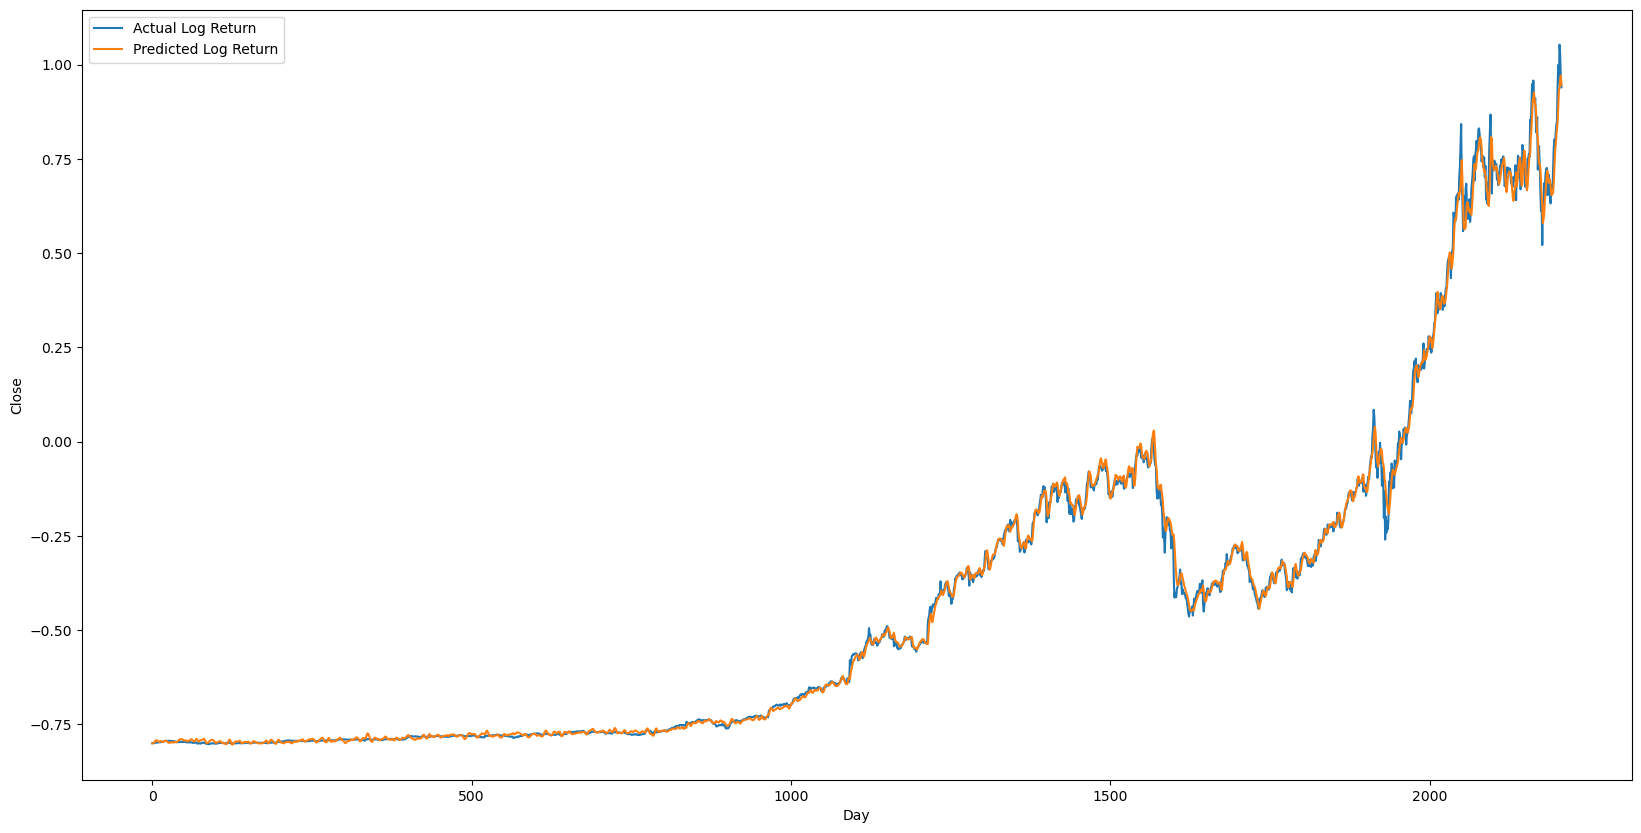

In [25]:
with torch.no_grad():
    predicted = model_optimal(X_train.to(device)).to('cpu').numpy()    # we have to move this to the cpu now because numpy cannot access the gpu

plt.figure(figsize=(20, 10))
plt.plot(y_train, label='Actual Log Return')
plt.plot(predicted, label='Predicted Log Return')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

The above data is still in the standardised form so now we perform some transformations to revert it back to the original scale

In [26]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))  # here we are basically trying to make a dummy matrix that 'looks like' the original matrix of data that we started with
dummies[:, 0] = train_predictions
dummies = price_scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

In [27]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = price_scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

Now plot the same as before but with our 'un-scaled' data

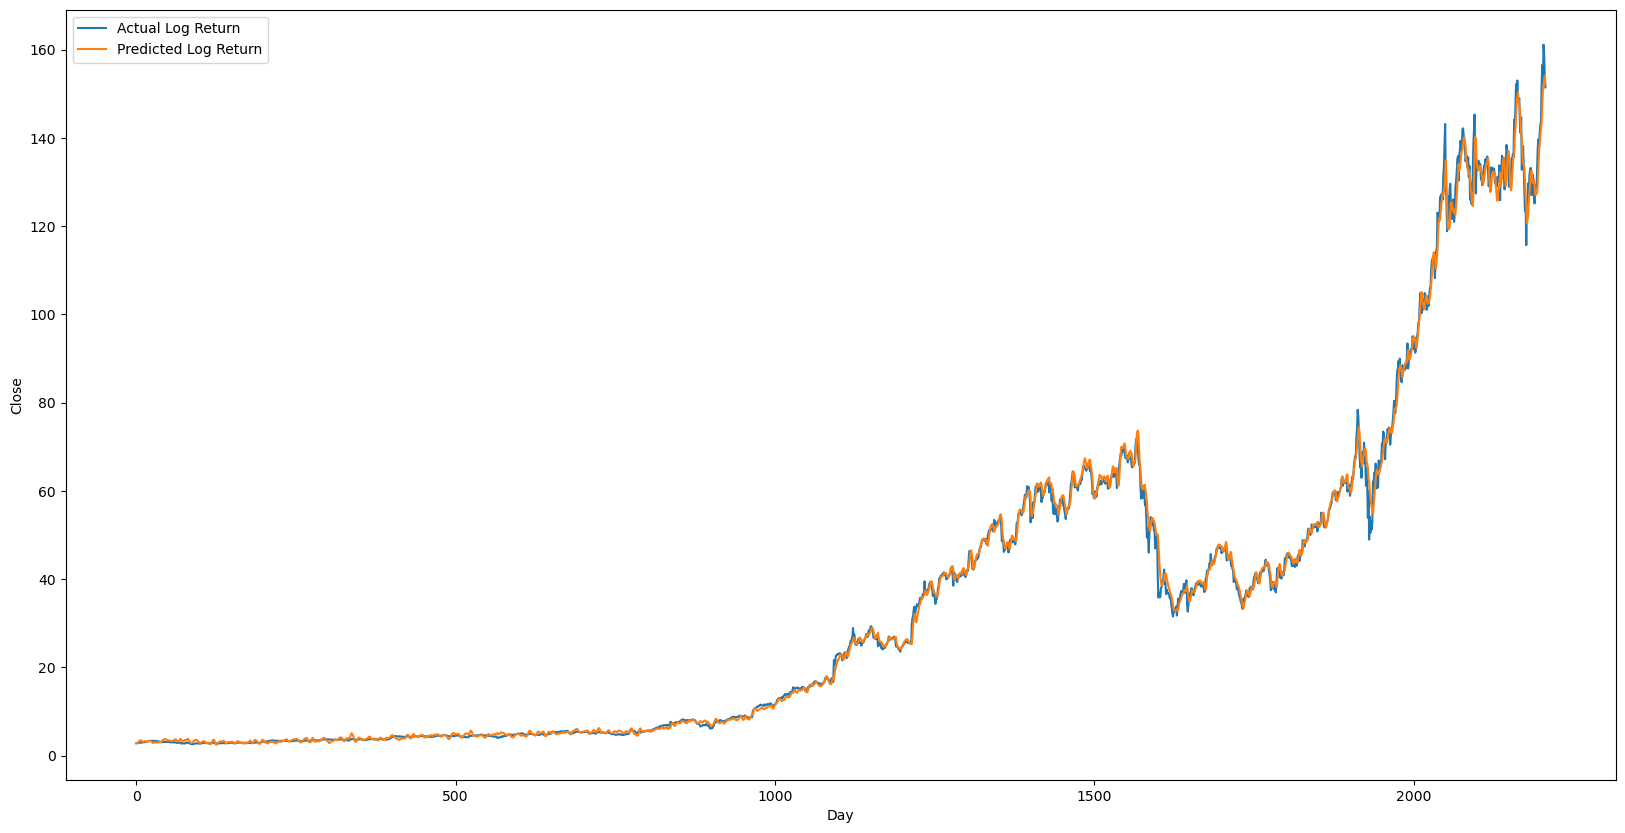

In [28]:
plt.figure(figsize=(20, 10))
plt.plot(new_y_train, label='Actual Log Return')
plt.plot(train_predictions, label='Predicted Log Return')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

## LSTM Test Predictions

First, we retrieve the dates of the test period

In [29]:
dates = df_ret.tail(len(X_test)).index

As before, we reverse the scaling on the predictions and y values

In [30]:
test_predictions = model_optimal(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = price_scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

In [31]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = price_scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

Then we plot them

In [1]:
plt.figure(figsize=(20, 10))
plt.plot(dates, new_y_test, label='Actual Log Return')
plt.plot(dates, test_predictions, label='Predicted Log Return')
plt.xlabel('Date')
plt.ylabel('NVIDIA Adjusted Close Price')
plt.title('LARGE LSTM Model Daily Price Forecasts vs Actuals')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

## Analysis

**Win Rate:** Simply put, is the proportion of the time that the model simply predicted the correct "direction"

In [33]:
# Calculate the differences between consecutive elements
actual_diff = np.diff(new_y_test)
predicted_diff = np.diff(test_predictions)

# Calculate the sign of the differences
actual_direction = np.sign(actual_diff)
predicted_direction = np.sign(predicted_diff)

# Calculate the number of correct predictions
correct_predictions = np.sum(actual_direction == predicted_direction)

# Calculate the win rate
win_rate = correct_predictions / len(actual_direction)

print("Win Rate: {:.2f}%".format(win_rate * 100))


Win Rate: 52.55%


**Root Mean Square Error (RMSE):** This metric tells you how close the predicted values are to the actual values. Lower values are better.

In [34]:
rmse = np.sqrt(mean_squared_error(new_y_test, test_predictions))
print(f'Root Mean Square Error: {rmse}')

Root Mean Square Error: 90.85334844513746


**Mean Absolute Error (MAE):** This metric is the average of the absolute differences between the predicted and actual values. It gives you an idea of how wrong your predictions were.

In [35]:
mae = mean_absolute_error(new_y_test, test_predictions)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 68.99288321623803


**Mean Absolute Percentage Error (MAPE):** This metric is similar to MAE, but it's expressed in relative terms. It's useful if you want to know the size of the prediction errors relative to the actual values.

In [36]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(new_y_test, test_predictions)
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Absolute Percentage Error: 22.289104895887405%


**R2 Score (Coefficient of Determination):** This metric tells you how well your model fits the data. A score of 1 means the model perfectly predicts the actual values, and a score of 0 means the model does not predict the actual values at all.

In [37]:
r2 = r2_score(new_y_test, test_predictions)
print(f'R2 Score: {r2}')

R2 Score: -0.25576617590341955


### Commentary

* **Win Rate:** 54.84%: This is relatively good for a binary prediction task like this (where we predict whether the target variable will go up or down). It suggests that the model is doing better than a random guess, which would have an expected win rate of 50%. However, there is still room for improvement.

* **Root Mean Square Error (RMSE):** 18.31: This metric tells us how close the model's predictions are to the actual values on average. A lower value is better. Depending on the scale of your target variable, this value may be considered high or low. In the context of financial forecasting, considering the large fluctuations that can occur, this might be acceptable.

* **Mean Absolute Error (MAE):** 12.67: This is the average magnitude of errors, regardless of their direction. It shows that the predictions were off by about 12.229 units on average. The interpretation is similar to RMSE; it's acceptability depends on the context and scale of the target variable.

* **Mean Absolute Percentage Error (MAPE):** 3.49%: This says that on average, the model's predictions are off by about 3.49% of the actual value. This is relatively low, suggesting the model's predictions are quite close to the actual values in relative terms.

* **R2 Score:** 0.91 This is a measure of how well the model's predicted values match the actual values. An R2 score of 1 means the model perfectly predicts the actual values. An R2 score of around 0.91 suggests that the model explains about 91% of the variability in the target variable, which is quite good.

In conclusion, these metrics suggest that the model is relatively good at predicting the direction of changes in the target variable (as shown by the win rate) and that the magnitudes of its predictions are typically within a few percentage points of the actual values (as shown by the MAPE). However, the relatively large RMSE and MAE suggest there might still be room for improvement, particularly in reducing the size of the larger errors.